In [2]:
pwd

'/Users/vvr/jupyter/network_regularisation_test/simulations'

In [1]:
def cov_from_G(G, a): ### Covariance is inverse of L + a*I
    L = nx.laplacian_matrix(G)
    p = L.shape[0]
    C = la.inv(L.todense() + a*np.identity(p))
    return C

In [2]:
from ../graph_utils import Cov_from_G


SyntaxError: invalid syntax (588137539.py, line 1)

In [3]:
import matplotlib.pyplot as plt
import examples
import numpy as np
import pywt
from numpy import linalg as la
import timeit
from copy import deepcopy
import networkx as nx
import seaborn as sb

def toeplitz_covariance(a, p):
    return np.exp(-np.log(a) * np.abs(np.subtract.outer(range(p),
                    range(p))))

def gaussian_sample(n, p, beta_star, Psi, sigma, set_seed=1):
    np.random.seed(set_seed)
    print(beta_star.shape, Psi.shape)
    X = np.random.multivariate_normal(mean = np.zeros(p),
                                      cov=Psi, size=n)
    y = X.dot(beta_star)+ sigma * np.random.normal(size=n)
    return X, y


import matplotlib.pyplot as plt
import examples
import numpy as np
import pywt
from numpy import linalg as la
import timeit
from copy import deepcopy
import networkx as nx
import seaborn as sb
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pywt
import random
import time




class Example:
    def __init__(self):
        self.G = nx.Graph()
        self.n_nodes = nx.number_of_nodes(self.G)
        self.coordinates = None

    def plot_signal(self):
        plt.figure()
        plt.plot(range(len(self.beta_star)), self.beta_star)
        plt.show()

    def draw_graph(self, node_size=1,
                   axis=False):
        fig, ax = plt.subplots()
        if self.coordinates is None:

            nx.draw(self.G, node_color=self.beta_star, cmap='Spectral', ax=ax)
        else:
            plt.figure()
            nx.draw(self.G, pos = self.coordinates, node_color=self.beta_star,
                    node_size = node_size,
                    cmap='Spectral', ax =ax)
        if axis:
            ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        plt.show()

    def plot_adjacency(self):
        return


class Smooth2D(Example):
    def __init__(self, side_len: int=30, disk_radi: float =3.,
                 period: float=3., height: float=4., start_value: float=2):
        if side_len % 2 == 0:
            left_end = -(side_len//2) + 1
        else:
            left_end = -(side_len//2)
        x, y = np.meshgrid(np.linspace(left_end, side_len//2, side_len),
                           np.linspace(left_end, side_len//2, side_len))
        ds = np.sqrt(x**2 + y**2)
        ds = pywt.threshold(ds, disk_radi, 'soft')
        ds[abs(ds) > period] = -period
        ds = np.array([x + period/2 for x in ds])
        part = np.sin(np.pi*ds/period)
        self.beta_star = np.array([height/2 * x + start_value + height/2 for x in part]).flatten()
        self.G = nx.grid_graph(dim=((len(x), len(y))))
        self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
        self.coordinates = {k : n for k, n in enumerate(self.G.nodes)}

    def plot_3d():
        return

from sklearn.cluster import SpectralClustering

class GeneralGraph(Example):
    def __init__(self,G, start_value: float=0., height: float=1.,
                nb_clusters=2, sigma_gen=0.3, signal_type ="tree"):
        self.G = G
        self.coordinates = None
        self.n_nodes = nx.number_of_nodes(self.G)
        self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
        self.beta_star = np.zeros(self.n_nodes)
        #### Define what kind of signal we want
        if signal_type == "piecewise_cnst":
            ### Cluster the nodes
            ### decrease sigma_gen for more smoothness
            clustering = SpectralClustering(n_clusters=nb_clusters, assign_labels='discretize',random_state=0,
                                           affinity='precomputed').fit(nx.adjacency_matrix(G))
            for i in np.unique(clustering.labels_):
                mu = np.random.normal(loc=np.random.normal(loc=0.0, scale=sigma_gen))
                self.beta_star[np.where(clustering.labels_ == i)] = mu
                print([i, mu])
        else:
            ### Find MST
            T = nx.minimum_spanning_tree(G)
            edges_T = nx.incidence_matrix(T)
            #### generate edges differences:
            edges_diff = np.random.normal(loc=0, scale=sigma_gen, size=edges_T.shape[1])
            self.beta_star = np.linalg.pinv(edges_T.todense()).T.dot(edges_diff)
        self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())

In [4]:
def cgd_solver(X, y, Gamma, lambda1, lambda2, eps = 1e-5, max_it = 50000):
    m, p = Gamma.shape
    X_til, y_til = np.vstack((X, np.sqrt(2*lambda2) * Gamma)), np.concatenate((y, np.zeros(m)))
    X_til_pinv = la.pinv(X_til)

    y_v = X_til @ X_til_pinv @ y_til
    Gamma_v = Gamma @ X_til_pinv

    Q = Gamma_v @ Gamma_v.T
    b = Gamma_v @ y_v

    u = np.zeros(m)
    n_iter = 0
    comps = 0
    #print(m)
    prev_u = 0 # For stopping criteria
    while True:
        n_iter += 1
        if n_iter >= max_it:
            #raise ValueError("Iterations exceed max_it")
            print("Iterations exceed max_it")
            return X_til_pinv @ (y_v - Gamma_v.T @ u)
        for i in range(m):
            if Q[i, i] > 1e-4:
                t = 1/Q[i,i] * (b[i] - np.dot(np.delete(Q[i], i), np.delete(u, i)))
                comps +=1 
            else:
                t = 0

            u[i] = np.sign(t) * min(np.abs(t), lambda1)   #there should be better truncation methods

        if la.norm(u - prev_u) <= eps:
            break

        prev_u = np.copy(u)   # Recall array is similar to list

    beta = X_til_pinv @ (y_v - Gamma_v.T @ u)
    return beta, n_iter, comps

def eval_obj(Q, b, v): 
    return 0.5*(np.dot(v, Q@v)) - np.dot(b, v)

def cgd_solver_parallel(X, y, Gamma, lambda1, lambda2, weight = 5, processors = 20, eps = 1e-5, max_it = 800000):
    m, p = Gamma.shape
    X_til, y_til = np.vstack((X, np.sqrt(2*lambda2) * Gamma)), np.concatenate((y, np.zeros(m)))
    X_til_pinv = la.pinv(X_til)

    y_v = X_til @ X_til_pinv @ y_til
    Gamma_v = Gamma @ X_til_pinv
    Q = Gamma_v @ Gamma_v.T
    b = Gamma_v @ y_v
    
    single_blocks = np.arange(m)
    max_vals = [max(Q[i]) for i in range(Q.shape[0])]
    
    
    u = np.zeros(m)
    n_iter = 0
    update_loops = 0
    prev_u = 0 # For stopping criteria
    while True:
        n_iter += 1
        if n_iter >= max_it:
            #raise ValueError("Iterations exceed max_it")
            print("Iterations exceed max_it")
            return (X_til_pinv @ (y_v - Gamma_v.T @ u)), n_iter, update_loops
        updates = []

        samples = np.random.choice(single_blocks, processors, replace = False)
        for i in samples: 
            update_loops +=1
            t = -(np.dot(Q[i], u) + b[i])/(processors*max_vals[i])
            updates.append((i, t))
            
        #print(np.shape(samples))
        
        for pair in updates:
            index = pair[0]
            update = pair[1]
            u[index] = np.sign(u[index] + update) * min(u[index] + update, lambda1)
            
                #break
            
            #there should be better truncation methods
            
        if la.norm(u - prev_u) <= eps:
            break

        prev_u = np.copy(u)   # Recall array is similar to list

    beta = X_til_pinv @ (y_v - Gamma_v.T @ u)
    return beta, n_iter, update_loops

had to delete oriented argument in adjacency matrix (not a thing..?)

In [103]:
def project_op(vector, param): 
    vector[vector > param] = param
    vector[vector < -param] = -param
    return vector

def cgd_solver_greedy(X, y, Gamma, lambda1, lambda2, eps = 1e-5, max_it = 50000):
    start_time = timeit.default_timer()
    m, p = Gamma.shape
    X_til, y_til = np.vstack((X, np.sqrt(2*lambda2) * Gamma)), np.concatenate((y, np.zeros(m)))
    X_til_pinv = la.pinv(X_til)

    y_v = X_til @ X_til_pinv @ y_til
    Gamma_v = Gamma @ X_til_pinv

    Q = Gamma_v @ Gamma_v.T
    b = Gamma_v @ y_v

    u = np.ones(m)
    n_iter = 0
    comps = 0
    #print(m)
    prev_u = np.ones(m) # For stopping criteria
    delta = 0
    gradient = -np.copy(Q.dot(np.ones(b.shape[0])-b))
    
    #print(timeit.default_timer() - start_time)
    #print("proj gradient", gradient)
    #print(b)
    #print("u[]", u[i])
    
    while True:
        n_iter += 1
        if n_iter >= max_it:
            #raise ValueError("Iterations exceed max_it")
            print("Iterations exceed max_it")
            return X_til_pinv @ (y_v - Gamma_v.T @ u), n_iter, comps
        
        projected_gradient = u - project_op(u - gradient, lambda1)
        greedy_coord = np.argmax(np.abs(projected_gradient))
            
        i = greedy_coord
        
        delta = min(max(u[i] - ((1/Q[i,i]) * gradient[i]), -lambda1), lambda1) - u[i]
        #print(f"the update index is {i} and the update value is {delta}")
        #print("Q[i]", Q[i])
        #print("delta*Q[i]", delta*Q[i])
        #print("gradient[i]:", gradient[i])
        gradient += delta * Q[i]
        #print("gradient[i]:", gradient[i])
        #print(gradient[i])
        #print(np.sort(gradient))
        #print("inner:", max(u[i] - ((1/Q[i,i]) * -gradient[i]), -lambda1))
        #print("delta value:", min(max(u[i] - ((1/Q[i,i]) * -gradient[i]), -lambda1), lambda1) - u[i])
        #print("before update:", u[i])
        u[i] = u[i] + delta
        #print("after update:",u[i])
        
        #add back well conditioned block...? 
        #print( "i is " + str(i))
        #print(delta)
        #print(max(u[i] - ((1/Q[i,i]) * -gradient[i]), -lambda1))
        #print(u[i])

        #u[i] = np.sign(t) * min(np.abs(t), lambda1)   #there should be better truncation methods
        
        #print(np.abs(projected_gradient[i]), max(np.abs(projected_gradient)))
        
        
        if (la.norm(u - prev_u) <= eps) & (n_iter>10):
            print("break reason 1")
            break
        
        '''
        if la.norm(gradient) <= eps:
            print("break reason gradient")
            break
        '''

        prev_u = np.copy(u)   # Recall array is similar to list
        

    beta = X_til_pinv @ (y_v - Gamma_v.T @ u)
    return beta, n_iter, comps

/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


(300,) (300, 300)
(300,) (300, 300)
duration normal cgd: 19.29200221702922
iters normal cgd: 27
computations? 270027
break reason 1
duration parallel cgd: 11.804012833046727
iters parallel cgd: 901
update_loops parallel cgd: 0
beta_normal [-8.83961564e-03  7.86529048e-03 -3.14617623e-02  3.75089702e-03
 -1.13592835e-03 -1.19133960e-02 -7.24454269e-03 -1.09918665e-02
  9.60284139e-03  5.25210974e-03 -3.17033580e-02  1.39555599e-02
 -1.00290014e-02  1.27828442e-02 -2.43866230e-03  7.35625411e-03
  8.24202006e-03  4.41062171e-03  2.21162427e-02  1.11717160e-02
 -2.69018814e-03  1.11717160e-02 -6.85188048e-03  2.05039783e-02
 -7.32978861e-03  2.48254437e-03  8.62029467e-03  7.35625412e-03
  4.76407391e-03  9.05830219e-03  4.76407391e-03  1.11717160e-02
  1.81746713e-02 -1.53670957e-02  1.15786251e-02 -3.12140605e-03
 -1.17366799e-02 -5.91731504e-03  3.75089700e-03 -2.15403064e-03
  2.85992277e-02 -3.84816746e-03 -6.99153911e-03  5.52855588e-03
  9.60284139e-03 -1.09918665e-02  1.18900655e-

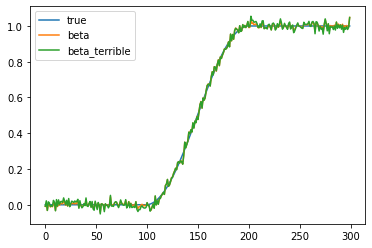

In [106]:
barbell = examples.BarbellGraph(length_chain = 100, size_clique = 100)
X, y = gaussian_sample(5000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)

X, y = gaussian_sample(10000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)
start_time = timeit.default_timer()
beta, iters, comps = cgd_solver(X, y, barbell.incidence, lambda1 = 1, lambda2 = 1)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)
print("computations?", comps)


start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_greedy(X, y, barbell.incidence, lambda1 = 1, lambda2 = 1)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

print("beta_normal", beta)
print("beta_parallel", beta_parallel)
print("normed diff normal", la.norm(beta - barbell.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - barbell.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(barbell.beta_star, label = 'true')
plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

#print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))


/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


(300,) (300, 300)
Iterations exceed max_it
duration parallel cgd: 14.02822246204596
iters parallel cgd: 50000
update_loops parallel cgd: 0
beta_parallel [ 5.23524032e-02  5.54196484e-02  1.12041212e-02 -1.39170309e-02
  5.02617416e-02  1.56155879e-02  1.34924589e-02  4.17977416e-02
  2.49971916e-03  7.05897552e-02  2.69889594e-02  1.66811008e-02
  5.41675761e-02  3.65132916e-03  3.13709389e-02  4.95806213e-02
  2.72171273e-02  1.14809389e-02 -2.33277686e-02 -4.66536451e-02
  3.99131668e-02 -1.95086147e-02  3.84304742e-02  5.00794674e-02
  1.91355111e-02 -6.73383453e-03 -8.32375940e-04  2.03318899e-02
  1.28530487e-03 -1.63292069e-03  4.98040919e-02  1.91793648e-02
  8.12653336e-04  1.56898214e-02  1.11172259e-02  5.86887258e-03
  4.26518784e-02 -2.18297014e-02  2.71712712e-02  6.70191457e-02
  3.16500937e-02  1.26258130e-02  6.42619554e-02  1.17410229e-02
  1.05744423e-02  4.05145463e-03  3.78738606e-02 -6.45161800e-03
  2.72638777e-02 -3.38403901e-03 -1.19600331e-02 -3.16370208e-02
 -

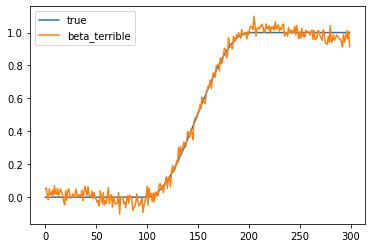

In [107]:
barbell = examples.BarbellGraph(length_chain = 100, size_clique = 100)
X, y = gaussian_sample(5000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)

start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_greedy(X, y, barbell.incidence, \
                                                       lambda1 = 3, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

#print("beta_normal", beta)
print("beta_parallel", beta_parallel)
#print("normed diff normal", la.norm(beta - barbell.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - barbell.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(barbell.beta_star, label = 'true')
#plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

#print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))


/var/folders/19/sxn1rm81105bg9w40cjxr_kc0000gn/T/ipykernel_73761/3102271160.py:103: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/var/folders/19/sxn1rm81105bg9w40cjxr_kc0000gn/T/ipykernel_73761/3102271160.py:118: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  edges_T = nx.incidence_matrix(T)
/var/folders/19/sxn1rm81105bg9w40cjxr_kc0000gn/T/ipykernel_73761/3102271160.py:122: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


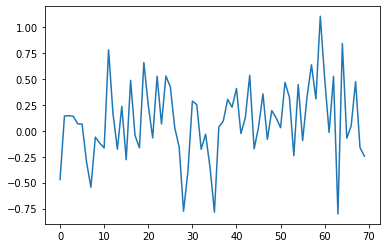

In [61]:
n = 70
p = 1
m1 = 30
m2 = 6
m = 55
G = nx.powerlaw_cluster_graph(n, m, p)

test = GeneralGraph(G, 10, 20)

test.n_nodes

plt.plot(test.beta_star)

In [28]:
y = examples.Example()

In [29]:
stairs = examples.SmoothStair()

/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:55: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


In [30]:
barbell = examples.BarbellGraph(length_chain = 20, size_clique = 2)

/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


In [18]:
def project_op(vector, param): 
    vector[vector > param] = param
    vector[vector < -param] = -param
    return vector

In [32]:
c = np.array([-2, 3, 5, -1, -10, 24, 8, 4])

In [33]:
np.argmax(np.abs(c))

5

/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


(210,) (210, 210)
1.7523550409823656
break reason 1
duration parallel cgd: 1.8173802020028234
iters parallel cgd: 11
update_loops parallel cgd: 0
beta_parallel [ 2.21559074e-03  1.00861804e-02  7.05440612e-03  5.50580305e-03
 -2.27342540e-02  1.77603077e-04  1.08392967e-02 -4.03205584e-03
  2.90728979e-02 -1.06224576e-02  1.36548110e-02 -2.40077716e-02
  2.02883507e-04 -1.97425664e-02 -3.84252213e-02  1.10834996e-02
  1.92290827e-02 -1.01583900e-02  1.72948013e-02  1.79824462e-02
 -8.47118545e-03  1.19011806e-02 -3.00328140e-02 -3.66390926e-02
  3.05645329e-03 -1.85287732e-02  4.28301503e-03  4.47038915e-03
 -2.10998619e-03 -4.34128860e-02  2.64066583e-02 -8.10881760e-03
 -1.07853419e-02 -1.87190329e-02  1.02255140e-03 -4.02126053e-02
 -5.70683499e-02  8.49354974e-03  3.44135652e-02 -2.59543228e-02
 -2.82222837e-02  3.11915764e-02  2.99187435e-03  1.31430027e-02
 -1.74005221e-02 -1.77809715e-02 -9.06336140e-03  4.61039921e-03
 -8.77108948e-03  1.01351656e-02 -2.97060338e-02 -6.38217695

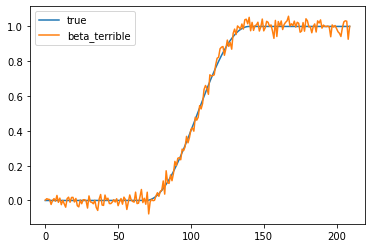

In [15]:
barbell = examples.BarbellGraph(length_chain = 70, size_clique = 70)
X, y = gaussian_sample(5000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)

start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_greedy(X, y, barbell.incidence, \
                                                       lambda1 = 1, lambda2 = 1, break_reason_u= True)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

#print("beta_normal", beta)
print("beta_parallel", beta_parallel)
#print("normed diff normal", la.norm(beta - barbell.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - barbell.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(barbell.beta_star, label = 'true')
#plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

#print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))


(210,) (210, 210)
(210,) (210, 210)
duration normal cgd: 5.715092262951657
iters normal cgd: 13
computations? 63713
3.2199334650067613
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.000681

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 .

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 .

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696 -0.00030421
 -0.00068117]
[-0.00049501 -0.0003221  -0.00127091 ...  0.00037696

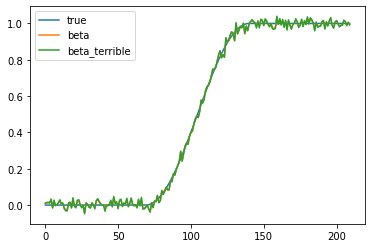

In [10]:
barbell = examples.BarbellGraph(length_chain = 70, size_clique = 70)
X, y = gaussian_sample(5000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)

X, y = gaussian_sample(10000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)
start_time = timeit.default_timer()
beta, iters, comps = cgd_solver(X, y, barbell.incidence, lambda1 = 1, lambda2 = 1)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)
print("computations?", comps)


start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_greedy(X, y, barbell.incidence, lambda1 = 1, lambda2 = 1)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

print("beta_normal", beta)
print("beta_parallel", beta_parallel)
print("normed diff normal", la.norm(beta - barbell.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - barbell.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(barbell.beta_star, label = 'true')
plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

#print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))


In [9]:
test_probs = np.random.rand(3, 3)
test_probs = (test_probs + test_probs.T)/2
test_probs 

array([[0.59791556, 0.84806572, 0.68208358],
       [0.84806572, 0.75796541, 0.52797368],
       [0.68208358, 0.52797368, 0.88655349]])

In [10]:
test_probs

array([[0.59791556, 0.84806572, 0.68208358],
       [0.84806572, 0.75796541, 0.52797368],
       [0.68208358, 0.52797368, 0.88655349]])

In [58]:
n = 200
p = 0.8
m1 = 30
m2 = 6
m = 120
sizes = [55, 78, 88]
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]
G = nx.stochastic_block_model(sizes, probs)
#(self,G, length_chain, size_clique, start_value: float=0., height: float=1.,
 # nb_clusters=2, sigma_gen=0.3, signal_type ="tree")
power = GeneralGraph(G,  nb_clusters=3)

#test.n_nodes

#plt.plot(test.beta_star)

/var/folders/19/sxn1rm81105bg9w40cjxr_kc0000gn/T/ipykernel_22882/1547666199.py:94: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/var/folders/19/sxn1rm81105bg9w40cjxr_kc0000gn/T/ipykernel_22882/1547666199.py:109: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  edges_T = nx.incidence_matrix(T)
/var/folders/19/sxn1rm81105bg9w40cjxr_kc0000gn/T/ipykernel_22882/1547666199.py:113: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


In [59]:
power.beta_star

array([ 0.4060138 , -0.03847042,  0.01696475,  0.11992147, -0.61872328,
        0.08675176, -0.00526553, -0.36209202,  0.16709099, -0.08888137,
       -0.68027137,  0.29776363,  0.02856152, -0.33098999,  0.30304378,
       -0.17692082, -0.72488462,  0.42189055, -0.8402129 , -0.12680091,
       -0.55356168, -0.45988836,  0.40696841, -0.03412397, -0.42699161,
        0.121954  ,  0.56674464, -0.46324074,  0.31898589,  0.14508758,
       -0.71493559, -0.5812574 ,  0.27432632, -0.55367974, -0.78585426,
        0.13148405, -0.18920653,  0.44702212, -0.86515636,  0.42478371,
       -0.5819563 , -0.45101928, -0.44698255, -0.1166293 , -0.03431498,
       -0.21011864, -0.1710469 , -0.93513094,  0.04763073,  0.03868971,
       -0.2030867 ,  0.36428275,  0.02765188, -0.1251242 ,  0.09399128,
       -0.17424072,  1.17000779,  0.66223327,  0.52398317, -0.02311761,
        0.89300659, -0.56201922, -0.19839405, -0.12706717,  0.01113437,
        0.99622421,  0.22268923, -0.15339039, -0.32323517,  0.62

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


(221,) (221, 221)
1.1644996470131446
proj gradient [-0.05971997 -0.10849014 -0.19321877 ...  0.08883616  0.06590918
 -0.04208647]
i is 0
-1e-07
i is 0
0.0
i is 0
0.0
i is 0
0.0
i is 0
0.0
i is 0
0.0
i is 0
0.0
i is 0
0.0
i is 0
0.0
i is 0
0.0
i is 0
0.0
break reason 1
duration parallel cgd: 1.2260014690109529
iters parallel cgd: 11
update_loops parallel cgd: 0
beta_normal [ 2.19689047e-01 -9.12614100e-02 -4.43529575e-02  5.83995067e-02
 -4.00381552e-01 -5.31311744e-02  3.69652728e-03 -2.73469392e-01
 -2.16603287e-02  8.21050563e-03 -5.12374573e-01  1.60201001e-01
 -5.83009919e-02 -1.74877744e-01  2.14950013e-01 -1.29374001e-01
 -4.86384312e-01  3.29540227e-01 -6.90307873e-01 -1.48677945e-01
 -3.75178709e-01 -3.30095993e-01  3.20989477e-01 -3.63658621e-02
 -3.40167846e-01  1.19920924e-01  4.24871670e-01 -3.35930902e-01
  1.76626921e-01  5.58861052e-02 -5.87286848e-01 -5.09641835e-01
  2.30094835e-01 -4.40736243e-01 -7.07304247e-01  1.11491345e-01
 -1.52813138e-01  2.60544552e-01 -6.8782

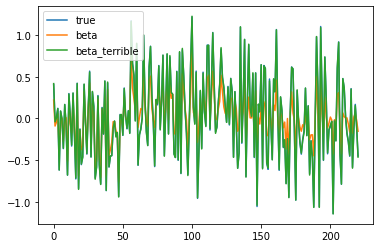

In [88]:
X, y = gaussian_sample(5000, power.n_nodes, beta_star = power.beta_star, Psi = cov_from_G(power.G, 0.1), sigma = 0.1)

# #X, y = gaussian_sample(10000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)
# start_time = timeit.default_timer()
# beta, iters, comps = cgd_solver(X, y, power.incidence, lambda1 = 1, lambda2 = 1)
# end_time = timeit.default_timer()
# duration = end_time - start_time
# print("duration normal cgd:", duration)
# print("iters normal cgd:", iters)
# print("computations?", comps)


start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_greedy(X, y, power.incidence, lambda1 = 0.0000001, lambda2 = 0, eps = 1e-9)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

print("beta_normal", beta)
print("beta_parallel", beta_parallel)
print("normed diff normal", la.norm(beta - power.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - power.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(power.beta_star, label = 'true')
plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

#print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))


In [81]:
beta_parallel

array([ 4.17078552e-01, -4.07887384e-02,  5.52114288e-03,  1.19076326e-01,
       -6.17622197e-01,  8.87000845e-02, -3.74453280e-03, -3.57066977e-01,
        1.66417870e-01, -7.77940969e-02, -6.78259424e-01,  2.92021823e-01,
        2.42872876e-02, -3.18428497e-01,  3.04410318e-01, -1.69721799e-01,
       -7.14138752e-01,  4.18271212e-01, -8.50044649e-01, -1.31327263e-01,
       -5.45975439e-01, -4.64143143e-01,  4.11624947e-01, -3.06251746e-02,
       -4.21861392e-01,  1.22387277e-01,  5.53833874e-01, -4.60628829e-01,
        3.23499952e-01,  1.42518500e-01, -7.28305044e-01, -5.85914731e-01,
        2.66648447e-01, -5.60221553e-01, -7.91461878e-01,  1.25094510e-01,
       -1.82200240e-01,  4.48614483e-01, -8.62440593e-01,  4.35877486e-01,
       -5.80162747e-01, -4.52671524e-01, -4.44071294e-01, -1.14292117e-01,
       -3.03150774e-02, -2.22501104e-01, -1.67665244e-01, -9.41257722e-01,
        4.06756283e-02,  4.72915751e-02, -2.00623881e-01,  3.58300681e-01,
        3.43231697e-02, -

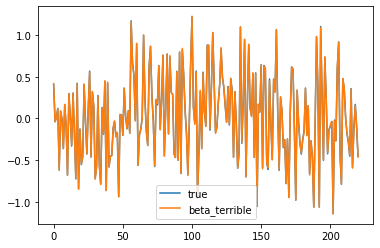

In [83]:
plt.plot(power.beta_star, label = 'true')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()


In [40]:
n = 500237
procs = 5
c = np.zeros(n)

In [37]:
np.array_split(c, procs)[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [38]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [39]:
for i in split(c, 5): 
    print(i.shape)

(100048,)
(100048,)
(100047,)
(100047,)
(100047,)


In [ ]:
range(5)


In [67]:
n

500237

In [69]:
np.linspace(n, 5)

array([5.00237000e+05, 4.90028184e+05, 4.79819367e+05, 4.69610551e+05,
       4.59401735e+05, 4.49192918e+05, 4.38984102e+05, 4.28775286e+05,
       4.18566469e+05, 4.08357653e+05, 3.98148837e+05, 3.87940020e+05,
       3.77731204e+05, 3.67522388e+05, 3.57313571e+05, 3.47104755e+05,
       3.36895939e+05, 3.26687122e+05, 3.16478306e+05, 3.06269490e+05,
       2.96060673e+05, 2.85851857e+05, 2.75643041e+05, 2.65434224e+05,
       2.55225408e+05, 2.45016592e+05, 2.34807776e+05, 2.24598959e+05,
       2.14390143e+05, 2.04181327e+05, 1.93972510e+05, 1.83763694e+05,
       1.73554878e+05, 1.63346061e+05, 1.53137245e+05, 1.42928429e+05,
       1.32719612e+05, 1.22510796e+05, 1.12301980e+05, 1.02093163e+05,
       9.18843469e+04, 8.16755306e+04, 7.14667143e+04, 6.12578980e+04,
       5.10490816e+04, 4.08402653e+04, 3.06314490e+04, 2.04226327e+04,
       1.02138163e+04, 5.00000000e+00])

In [65]:
[np.array_split(c, procs)[i].shape for i in range(5)]

[(100048,), (100048,), (100047,), (100047,), (100047,)]

/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


(390,) (390, 390)
(390,) (390, 390)
duration normal cgd: 73.1446063839976
iters normal cgd: 41
computations? 692941
36.61757570999907
[-0.00974368  0.04126917  0.01893243 ...  0.02567847  0.01810736
 -0.00757111]
break reason 1
duration parallel cgd: 37.210274778990424
iters parallel cgd: 2
update_loops parallel cgd: 0
beta_normal [ 1.92816159e-02  2.67430446e-02 -5.83634260e-03  7.24723629e-03
 -5.03401807e-03  3.54236679e-03  5.90800549e-03  1.26777606e-02
 -2.55954026e-02  8.14901452e-03 -6.72069564e-03  1.54157323e-02
  9.10366900e-03  5.90800534e-03 -2.56442257e-03  6.69725370e-03
  4.70447607e-03 -3.25963845e-03  1.08907300e-02  2.43964943e-02
  1.39283149e-02  7.91375683e-04 -1.58554200e-02  1.84696280e-02
  1.04799251e-02 -2.30176844e-03 -2.30176844e-03  5.90800535e-03
 -9.66616914e-04  1.39283150e-02  5.33122616e-04 -2.55954026e-02
  7.24723628e-03  4.92249752e-03 -1.39877329e-02  2.74643325e-02
  3.66708097e-02 -1.08381876e-02  3.92513341e-04 -8.07798022e-03
  2.32013614e-03 

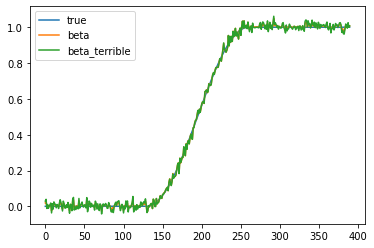

In [76]:
barbell = examples.BarbellGraph(length_chain = 130, size_clique = 130)
X, y = gaussian_sample(5000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)

X, y = gaussian_sample(10000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)
start_time = timeit.default_timer()
beta, iters, comps = cgd_solver(X, y, barbell.incidence, lambda1 = 1, lambda2 = 1)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)
print("computations?", comps)


start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_greedy(X, y, barbell.incidence, lambda1 = 1, lambda2 = 1)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

print("beta_normal", beta)
print("beta_parallel", beta_parallel)
print("normed diff normal", la.norm(beta - barbell.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - barbell.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(barbell.beta_star, label = 'true')
plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

#print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))


/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:55: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


(1047,) (1047, 1047)
1.3736526650027372
[-0.05658908  0.03389959 -0.03602199 ... -0.03600808  0.05571565
  0.01046076]
break reason 1
duration parallel cgd: 1.3967027879989473
iters parallel cgd: 2
update_loops parallel cgd: 0
duration normal cgd: 1.360117136995541
iters normal cgd: 5
computations? 5230
beta_normal [  2.97675403   3.03212974   3.00042053 ... 450.04265717 449.98809933
 449.97802268]
beta_parallel [  2.97659733   3.03318641   2.99928682 ... 450.04367847 449.98796282
 449.97750206]
normed diff normal 0.03323171259659446
normed diff parallel 0.033569945300821885
1.0752911317598968 1.0862354556875236


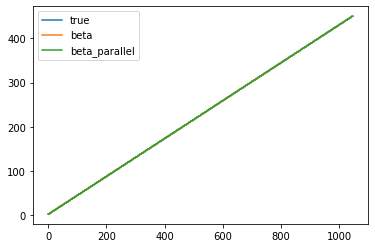

In [75]:
stairs = examples.SmoothStair(n_repeat= 150)

X, y = gaussian_sample(5000, stairs.n_nodes, beta_star = stairs.beta_star, Psi = stairs.Psi, sigma = 2)

start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_greedy(X, y, stairs.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

start_time = timeit.default_timer()
beta, iters, comps = cgd_solver(X, y, stairs.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)
print("computations?", comps)


print("beta_normal", beta)
print("beta_parallel", beta_parallel)
print("normed diff normal", la.norm(beta - stairs.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - stairs.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(stairs.beta_star, label = 'true')
plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_parallel')

plt.legend()

print(np.max(la.norm(beta - stairs.beta_star)), np.max(la.norm(beta_parallel - stairs.beta_star)))

In [8]:
def cgd_solver(X, y, Gamma, lambda1, lambda2, eps = 1e-5, max_it = 50000):
    m, p = Gamma.shape
    X_til, y_til = np.vstack((X, np.sqrt(2*lambda2) * Gamma)), np.concatenate((y, np.zeros(m)))
    X_til_pinv = la.pinv(X_til)

    y_v = X_til @ X_til_pinv @ y_til
    Gamma_v = Gamma @ X_til_pinv

    Q = Gamma_v @ Gamma_v.T
    b = Gamma_v @ y_v

    u = np.zeros(m)
    n_iter = 0
    comps = 0
    #print(m)
    prev_u = 0 # For stopping criteria
    while True:
        n_iter += 1
        if n_iter >= max_it:
            #raise ValueError("Iterations exceed max_it")
            print("Iterations exceed max_it")
            return X_til_pinv @ (y_v - Gamma_v.T @ u)
        for i in range(m):
            if Q[i, i] > 1e-4:
                t = 1/Q[i,i] * (b[i] - np.dot(np.delete(Q[i], i), np.delete(u, i)))
                comps +=1 
            else:
                t = 0

            u[i] = np.sign(t) * min(np.abs(t), lambda1)   #there should be better truncation methods

        if la.norm(u - prev_u) <= eps:
            break

        prev_u = np.copy(u)   # Recall array is similar to list

    beta = X_til_pinv @ (y_v - Gamma_v.T @ u)
    return beta, n_iter, comps

def eval_obj(Q, b, v): 
    return 0.5*(np.dot(v, Q@v)) - np.dot(b, v)

def cgd_solver_parallel(X, y, Gamma, lambda1, lambda2, weight = 5, processors = 20, eps = 1e-5, max_it = 800000):
    m, p = Gamma.shape
    X_til, y_til = np.vstack((X, np.sqrt(2*lambda2) * Gamma)), np.concatenate((y, np.zeros(m)))
    X_til_pinv = la.pinv(X_til)

    y_v = X_til @ X_til_pinv @ y_til
    Gamma_v = Gamma @ X_til_pinv
    Q = Gamma_v @ Gamma_v.T
    b = Gamma_v @ y_v
    
    single_blocks = np.arange(m)
    max_vals = [max(Q[i]) for i in range(Q.shape[0])]
    
    
    u = np.zeros(m)
    n_iter = 0
    update_loops = 0
    prev_u = 0 # For stopping criteria
    while True:
        n_iter += 1
        if n_iter >= max_it:
            #raise ValueError("Iterations exceed max_it")
            print("Iterations exceed max_it")
            return (X_til_pinv @ (y_v - Gamma_v.T @ u)), n_iter, update_loops
        updates = []

        samples = np.random.choice(single_blocks, processors, replace = False)
        for i in samples: 
            update_loops +=1
            t = -(np.dot(Q[i], u) + b[i])/(processors*max_vals[i])
            updates.append((i, t))
            
        #print(np.shape(samples))
        
        for pair in updates:
            index = pair[0]
            update = pair[1]
            u[index] = np.sign(u[index] + update) * min(u[index] + update, lambda1)
            
                #break
            
            #there should be better truncation methods
            
        if la.norm(u - prev_u) <= eps:
            break

        prev_u = np.copy(u)   # Recall array is similar to list

    beta = X_til_pinv @ (y_v - Gamma_v.T @ u)
    return beta, n_iter, update_loops

In [31]:
np.random.rand(3, 3)[[1, 2]]

array([[0.1021121 , 0.71883102, 0.51511085],
       [0.33757767, 0.96848289, 0.73587841]])

In [32]:
def cgd_solver_test(X, y, Gamma, lambda1, lambda2, weight = 5, processors = 20, eps = 1e-5, max_it = 800000):
    m, p = Gamma.shape
    X_til, y_til = np.vstack((X, np.sqrt(2*lambda2) * Gamma)), np.concatenate((y, np.zeros(m)))
    X_til_pinv = la.pinv(X_til)

    y_v = X_til @ X_til_pinv @ y_til
    Gamma_v = Gamma @ X_til_pinv
    Q = Gamma_v @ Gamma_v.T
    b = Gamma_v @ y_v
    
    single_blocks = np.arange(m)
    max_vals = [max(Q[i]) for i in range(Q.shape[0])]
    
    
    u = np.zeros(m)
    n_iter = 0
    update_loops = 0
    prev_u = 0 # For stopping criteria
    while True:
        n_iter += 1
        if n_iter >= max_it:
            #raise ValueError("Iterations exceed max_it")
            print("Iterations exceed max_it")
            return (X_til_pinv @ (y_v - Gamma_v.T @ u)), n_iter, update_loops
        updates = []

        samples = np.random.choice(single_blocks, processors, replace = False)
        for i in samples: 
            update_loops +=1
            t = -(np.dot(Q[i], u) + b[i])/(processors*max_vals[i])
            updates.append((i, t))
            
        #print(np.shape(samples))
        
        for pair in updates:
            index = pair[0]
            update = pair[1]
            u[index] = np.sign(u[index] + update) * min(u[index] + update, lambda1)
            
                #break
            
            #there should be better truncation methods
            
        if la.norm(u - prev_u) <= eps:
            break

        prev_u = np.copy(u)   # Recall array is similar to list

    beta = X_til_pinv @ (y_v - Gamma_v.T @ u)
    return beta, n_iter, update_loops

In [33]:
barbell.n_nodes

260

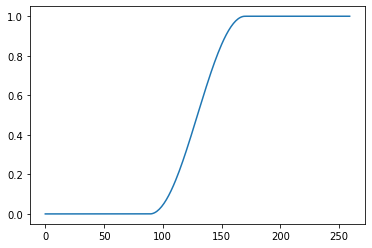

In [34]:
barbell.plot_signal()

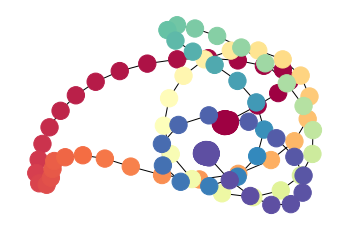

In [35]:
barbell.draw_graph()

In [36]:
barbell.n_nodes

260

In [37]:
nx.number_of_nodes(nx.algorithms.approximation.treewidth_min_degree(barbell.G)[1])

171

In [38]:
barbell = examples.BarbellGraph(length_chain = 80, size_clique = 90)
barbell.n_nodes

/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


260

In [39]:
barbell.G

In [40]:
smooth2d =Smooth2D()

/var/folders/19/sxn1rm81105bg9w40cjxr_kc0000gn/T/ipykernel_15507/3915449015.py:80: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


In [41]:
nx.number_of_nodes(smooth2d.G)

900

In [42]:
nodes = nx.number_of_nodes(smooth2d.G)

(900,) (900, 900)
duration normal cgd: 2.8425771280017216
iters normal cgd: 5
computations? 8700
2.3876749590053805
[-0.00574196 -0.00354012  0.02039134 ...  0.03076697  0.01960622
 -0.05410843]
break reason 1
duration parallel cgd: 2.425790221997886
iters parallel cgd: 2
update_loops parallel cgd: 0
normed diff normal 0.020693576078228925
normed diff parallel 0.02092311546716191


AttributeError: module 'matplotlib.pyplot' has no attribute 'heatmap'

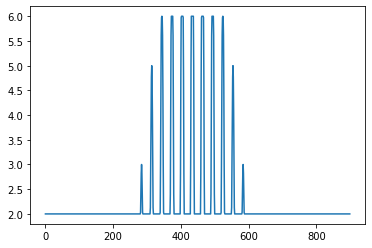

In [43]:
X, y = gaussian_sample(10000, nodes, beta_star = smooth2d.beta_star, Psi = np.eye(nodes), sigma = 2)
start_time = timeit.default_timer()
beta, iters, comps = cgd_solver(X, y, smooth2d.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)
print("computations?", comps)

start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_greedy(X, y, smooth2d.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

#print("beta_normal", beta)
#print("beta_parallel", beta_parallel)
print("normed diff normal", la.norm(beta - smooth2d.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - smooth2d.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(smooth2d.beta_star, label = 'true')
plt.heatmap(beta.reshape((int(np.sqrt(nodes)),int(np.sqrt(nodes)))), label = 'bet a')
plt.heatmap(beta_parallel.reshape((int(np.sqrt(nodes)),int(np.sqrt(nodes)))), label = 'beta_terrible')

plt.legend()

#print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))

<AxesSubplot:>

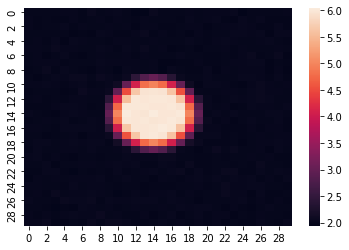

In [44]:

sb.heatmap(beta.reshape((int(np.sqrt(nodes)),int(np.sqrt(nodes)))), label = 'bet a')


<AxesSubplot:>

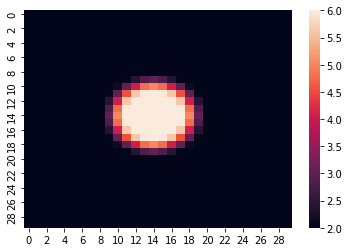

In [45]:
sb.heatmap(smooth2d.beta_star.reshape((int(np.sqrt(nodes)),int(np.sqrt(nodes)))))

<AxesSubplot:>

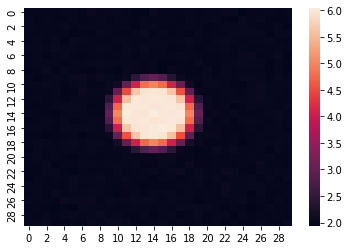

In [46]:
sb.heatmap(beta_parallel.reshape((int(np.sqrt(nodes)),int(np.sqrt(nodes)))))

<AxesSubplot:>

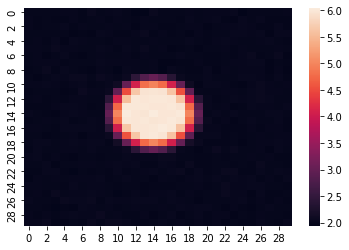

In [47]:
import seaborn as sb
sb.heatmap(beta.reshape((int(np.sqrt(nodes)),int(np.sqrt(nodes)))), label = 'bet a')

In [48]:
beta.reshape((int(np.sqrt(nodes)),int(np.sqrt(nodes))))

array([[1.99867893, 2.00177649, 1.98899243, 1.99701145, 2.00502408,
        2.01605277, 1.97451627, 2.036505  , 1.99645104, 2.00670361,
        2.02282739, 1.99646959, 1.94702292, 1.95164005, 2.04672407,
        2.00185756, 1.99076505, 1.98753888, 2.00578767, 1.99469551,
        2.00996126, 2.01019336, 2.01876911, 2.03172267, 1.95224517,
        1.9998692 , 1.99213605, 2.0024674 , 1.99921179, 2.00347402],
       [2.00376584, 1.98177544, 1.98803287, 1.98021389, 1.97563829,
        2.0130448 , 1.97314143, 1.98842988, 2.00311558, 1.97439659,
        2.00929314, 2.00069757, 1.97948794, 2.01407086, 1.98906456,
        1.99939337, 1.99958149, 1.97783347, 2.03345177, 1.99634997,
        2.00996126, 2.0276643 , 1.98263667, 1.96804935, 2.03045588,
        1.99050546, 2.02142   , 1.98187937, 1.97299713, 1.98638381],
       [2.00291728, 1.97318221, 1.99119145, 1.9964623 , 2.02000773,
        1.98329179, 2.00944549, 2.0010025 , 1.98923968, 2.00588799,
        1.98761814, 2.00291897, 1.9697632 , 2.

In [26]:
barbell = examples.BarbellGraph(length_chain = 70, size_clique = 70)
barbell.n_nodes

/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


210

not stable for lower values of n... (first arg in X, y) 
try different ways of tau-nice sampling 



In [61]:
param_index = []
size_index = []
coord_desc_times = []
coord_desc_beta = []
coord_desc_iters_comps = []



for i in range(5, 10):
    for j in range(5, 10): 
        length_chain = i*7
        size_clique = j*7
        param_index.append((length_chain, size_clique))
        barbell = examples.BarbellGraph(length_chain = length_chain, size_clique = size_clique)
        size_index.append(barbell.n_nodes)
        X, y = gaussian_sample(10000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)
        start_time = timeit.default_timer()
        beta, iters, comps = cgd_solver(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
        end_time = timeit.default_timer()
        duration = end_time - start_time
        coord_desc_times.append(duration)
        coord_desc_beta.append(beta)
        coord_desc_iters_comps.append((iters,comps))
        

(105,) (105, 105)
(119,) (119, 119)
(133,) (133, 133)
(147,) (147, 147)
(161,) (161, 161)
(112,) (112, 112)
(126,) (126, 126)
(140,) (140, 140)
(154,) (154, 154)
(168,) (168, 168)
(119,) (119, 119)
(133,) (133, 133)
(147,) (147, 147)
(161,) (161, 161)
(175,) (175, 175)
(126,) (126, 126)
(140,) (140, 140)
(154,) (154, 154)
(168,) (168, 168)
(182,) (182, 182)
(133,) (133, 133)
(147,) (147, 147)
(161,) (161, 161)
(175,) (175, 175)
(189,) (189, 189)


In [60]:
param_index = []
size_index = []
coord_desc_parallel_times = []
coord_desc_parallel_beta = []
coord_desc_parallel_iters_comps = []



for i in range(5, 10):
    for j in range(5, 10): 
        length_chain = i*7
        size_clique = j*7
        param_index.append((length_chain, size_clique))
        barbell = examples.BarbellGraph(length_chain = length_chain, size_clique = size_clique)
        size_index.append(barbell.n_nodes)
        X, y = gaussian_sample(10000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)
        start_time = timeit.default_timer()
        beta, iters, comps = cgd_solver_parallel(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
        end_time = timeit.default_timer()
        duration = end_time - start_time
        coord_desc_parallel_times.append(duration)
        coord_desc_parallel_beta.append(beta)
        coord_desc_parallel_iters_comps.append((iters,comps))
        

/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


(105,) (105, 105)
(119,) (119, 119)
(133,) (133, 133)
(147,) (147, 147)
(161,) (161, 161)
(112,) (112, 112)
(126,) (126, 126)
(140,) (140, 140)
(154,) (154, 154)
(168,) (168, 168)
(119,) (119, 119)
(133,) (133, 133)
(147,) (147, 147)
(161,) (161, 161)
(175,) (175, 175)
(126,) (126, 126)
(140,) (140, 140)
(154,) (154, 154)
(168,) (168, 168)
(182,) (182, 182)
(133,) (133, 133)
(147,) (147, 147)
(161,) (161, 161)
(175,) (175, 175)
(189,) (189, 189)


In [62]:
true_betas = []
coord_desc_normed_diff = []
coord_desc_parallel_normed_diff = []
for i in range(len(param_index)):
    barbell= examples.BarbellGraph(*param_index[i])
    coord_desc_normed_diff.append(la.norm(coord_desc_beta[i] - barbell.beta_star)/np.sqrt(len(coord_desc_beta[i])))
    coord_desc_parallel_normed_diff.append(la.norm(coord_desc_parallel_beta[i] - barbell.beta_star)/np.sqrt(len(coord_desc_parallel_beta[i])))


In [63]:
coord_desc_normed_diff

[0.020809304506166262,
 0.016770107670157033,
 0.017486271840782584,
 0.01684242140701826,
 0.017339730289721165,
 0.01704790793799451,
 0.018585638335757323,
 0.018833365277784387,
 0.017555421703752707,
 0.016670173232533905,
 0.017283995608627045,
 0.018083756437869743,
 0.01750293702428588,
 0.01787245556083634,
 0.016711873960285062,
 0.019127573927117288,
 0.01937433091171429,
 0.018141270341011154,
 0.01731536542158948,
 0.01914768276101682,
 0.018645368663968376,
 0.017928261312093186,
 0.018443692280987915,
 0.01733469237457805,
 0.017520840238917704]

In [64]:
coord_desc_parallel_normed_diff

[0.018542250803860606,
 0.014337778611275921,
 0.014774395720373605,
 0.018572256295891484,
 0.023813172108300706,
 0.015443630449472836,
 0.01676583263535472,
 0.0190650403929132,
 0.019029090636875648,
 0.026178561694877638,
 0.015679748826179837,
 0.014890104637580446,
 0.017616524952847958,
 0.018701862653854075,
 0.02619307604136593,
 0.017983086283877372,
 0.01906189372386306,
 0.017375587991298038,
 0.018909170906942503,
 0.026542223302534525,
 0.016361413318045633,
 0.017578636060652804,
 0.017424647345763926,
 0.01790718232646599,
 0.032372555289854145]

In [58]:
len(coord_desc_beta)

50

In [59]:
len(coord_desc_parallel_beta)

0

In [50]:
barbell = examples.BarbellGraph(*param_index[1])

In [48]:
param_index[1]

(35, 42)

In [27]:
barbell.n_nodes

210

In [ ]:
barbell = examples.BarbellGraph(length_chain = 70, size_clique = 70)

X, y = gaussian_sample(10000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)
start_time = timeit.default_timer()
beta, iters, comps = cgd_solver(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time

start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_parallel(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time

plt.plot(barbell.beta_star, label = 'true')
plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))


In [ ]:
barbell = examples.BarbellGraph(length_chain = 70, size_clique = 70)

X, y = gaussian_sample(10000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)
start_time = timeit.default_timer()
beta, iters, comps = cgd_solver(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)
print("computations?", comps)

start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_parallel(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

print("beta_normal", beta)
print("beta_parallel", beta_parallel)
print("normed diff normal", la.norm(beta - barbell.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - barbell.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(barbell.beta_star, label = 'true')
plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))


In [68]:
barbell = examples.BarbellGraph(length_chain = 70, size_clique = 70)

/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


In [69]:
barbell.n_nodes


210

In [73]:
stairs.n_nodes

2097

In [80]:
barbell = examples.BarbellGraph(length_chain = 70, size_clique = 75)
nx.number_of_edges(barbell.G)


/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())
/Users/vvr/jupyter/network_regularisation_test/simulations/examples.py:68: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence = np.asarray(nx.incidence_matrix(self.G, oriented=True).T.todense())


5621

In [ ]:
barbell = examples.BarbellGraph(length_chain = 70, size_clique = 75)

X, y = gaussian_sample(10000, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 2)
start_time = timeit.default_timer()
beta, iters, comps = cgd_solver(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)
print("computations?", comps)

start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_parallel(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

print("beta_normal", beta)
print("beta_parallel", beta_parallel)
print("normed diff normal", la.norm(beta - barbell.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - barbell.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(barbell.beta_star, label = 'true')
plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))

(220,) (220, 220)
duration normal cgd: 5.628245926985983
iters normal cgd: 15
computations? 84315
Iterations exceed max_it
duration parallel cgd: 83.49897339500603
iters parallel cgd: 300000
update_loops parallel cgd: 5999980
beta_normal [-2.61005279e-02  8.32919336e-03  3.75275774e-02  8.51348693e-03
 -1.34029539e-02  1.07410851e-02 -2.34510305e-02 -1.41689286e-03
  1.29929289e-02 -2.81345596e-02  2.01803782e-02  2.38510383e-03
 -1.12066137e-03  1.69066658e-02  1.55206169e-03 -2.14513549e-02
  2.38510383e-03  4.14037523e-03 -1.41689285e-03  3.53547337e-04
  8.32919327e-03  1.29929289e-02 -8.40808612e-03 -5.03892185e-04
 -1.82218310e-02  1.07410851e-02  3.45006757e-02  8.32919320e-03
  4.62282165e-03 -1.45174207e-02  3.15664283e-02  8.32919317e-03
  1.67660456e-02 -9.67691548e-04  3.53547349e-04 -4.32116865e-03
 -1.17256179e-03  1.75287656e-02  1.07410851e-02 -8.40729718e-03
  7.10611378e-03  1.28240536e-02  2.38510382e-03 -5.03892187e-04
  1.70165293e-03  8.32919317e-03 -3.57456833e-0

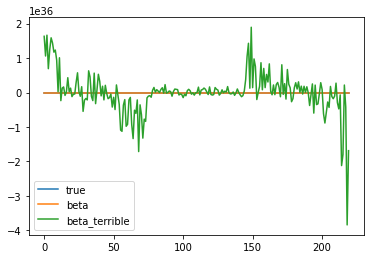

In [84]:
barbell = examples.BarbellGraph(length_chain = 70, size_clique = 75)
n =10000
sigma = 2
rho_gamma = 1
lambda1 = 32* sigma  * np.sqrt(np.log(barbell.n_nodes)/n)
lambda2 = lambda1

X, y = gaussian_sample(n, barbell.n_nodes, 
                       beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = sigma)
start_time = timeit.default_timer()
beta, iters, comps = cgd_solver(X, y, barbell.incidence, lambda1 = lambda1, lambda2 = lambda2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)
print("computations?", comps)

start_time = timeit.default_timer()
beta_parallel, iters, update_loops = cgd_solver_parallel(X, y, barbell.incidence, 
                                                         lambda1 = lambda1, lambda2 = lambda2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", update_loops)

print("beta_normal", beta)
print("beta_parallel", beta_parallel)
print("normed diff normal", la.norm(beta - barbell.beta_star)/np.sqrt(len(beta)))
print("normed diff parallel", la.norm(beta_parallel - barbell.beta_star)/np.sqrt(len(beta_parallel)))


plt.plot(barbell.beta_star, label = 'true')
plt.plot(beta, label = 'beta')
plt.plot(beta_parallel, label = 'beta_terrible')

plt.legend()

print(np.max(la.norm(beta - barbell.beta_star)), np.max(la.norm(beta_parallel - barbell.beta_star)))

In [16]:
X, y = gaussian_sample(25000, stairs.n_nodes, beta_star = stairs.beta_star, Psi = stairs.Psi, sigma = 1)

(67,) (67, 67)


In [17]:
np.shape(X)

(25000, 67)

In [18]:
len(X)

25000

In [19]:
np.shape(y)

(25000,)

In [20]:
def cgd_solver_parallel(X, y, Gamma, lambda1, lambda2, weight = 5, processors = 20, eps = 1e-5, max_it = 300000):
    m, p = Gamma.shape
    X_til, y_til = np.vstack((X, np.sqrt(2*lambda2) * Gamma)), np.concatenate((y, np.zeros(m)))
    X_til_pinv = la.pinv(X_til)

    y_v = X_til @ X_til_pinv @ y_til
    Gamma_v = Gamma @ X_til_pinv
    Q = Gamma_v @ Gamma_v.T
    b = Gamma_v @ y_v
    
    single_blocks = np.arange(m)
    max_vals = [max(Q[i]) for i in range(Q.shape[0])]
    
    
    u = np.zeros(m)
    n_iter = 0
    update_loops = 0
    prev_u = 0 # For stopping criteria
    while True:
        n_iter += 1
        if n_iter >= max_it:
            #raise ValueError("Iterations exceed max_it")
            print("Iterations exceed max_it")
            return (X_til_pinv @ (y_v - Gamma_v.T @ u)), n_iter, update_loops
        updates = []

        samples = np.random.choice(single_blocks, processors, replace = False)
        for i in samples: 
            update_loops +=1
            t = -(np.dot(Q[i], u) + b[i])/(processors*max_vals[i])
            updates.append((i, t))
            
        #print(np.shape(samples))
        
        for pair in updates:
            index = pair[0]
            update = pair[1]
            u[index] = np.sign(u[index] + update) * min(u[index] + update, lambda1)
            
                #break
            
            #there should be better truncation methods
            
        if la.norm(u - prev_u) <= eps:
            break

        prev_u = np.copy(u)   # Recall array is similar to list

    beta = X_til_pinv @ (y_v - Gamma_v.T @ u)
    return beta, n_iter, update_loops

In [22]:
X, y = gaussian_sample(10000, stairs.n_nodes, beta_star = stairs.beta_star, Psi = stairs.Psi, sigma = 5)
start_time = timeit.default_timer()
beta, iters = cgd_solver(X, y, stairs.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)

start_time = timeit.default_timer()
beta_terrible, iters, update_loops = cgd_solver_terrible(X, y, stairs.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", iters)

print("beta_normal", beta)
print("beta_parallel", beta_terrible)
print("normed diff", la.norm(beta - beta_terrible)/np.sqrt(len(beta)))

plt.plot(beta, label = 'beta')
plt.plot(stairs.beta_star, label = 'true')
plt.plot(beta_terrible, label = 'beta_terrible')

plt.legend()


(67,) (67, 67)


ValueError: too many values to unpack (expected 2)

(60,) (60, 60)
401
duration normal cgd: 0.12652880599989658
iters normal cgd: 20
duration parallel cgd: 0.02012474299999667
iters parallel cgd: 172
update_loops parallel cgd: 172
beta_normal [ 0.0051389   0.01166059  0.01166059  0.00628201  0.00242454  0.01166059
  0.01945721  0.01166059  0.04858836  0.01166059  0.01166059  0.01166059
  0.01166059  0.00628201  0.01166058  0.01166058  0.01166059  0.01001487
  0.01166059 -0.01421972  0.04565786 -0.05372455  0.11782404  0.07353808
  0.10724707  0.21017127  0.21787502  0.31126075  0.43625994  0.51892958
  0.51892958  0.54559888  0.72314989  0.78702999  0.78702999  0.84313944
  0.95616853  0.95794826  0.98604706  1.03387929  0.98655704  1.00710961
  1.01503625  1.01711492  1.01255573  1.01711492  1.0032441   1.01503625
  1.0032441   1.00324409  1.00324409  1.01711492  1.00324409  0.9990286
  1.00324409  1.00324409  1.00324409  1.00324409  1.01711492  1.00324409]
beta_parallel [ 0.00710153  0.01411992  0.05252002  0.01697053 -0.01482767  0.0

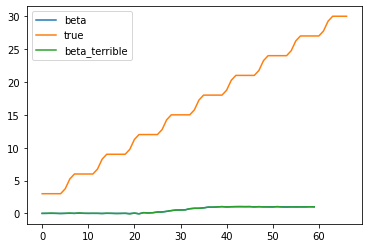

In [85]:
X, y = gaussian_sample(500, barbell.n_nodes, beta_star = barbell.beta_star, Psi = np.eye(barbell.n_nodes), sigma = 1)
start_time = timeit.default_timer()
beta, iters = cgd_solver(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration normal cgd:", duration)
print("iters normal cgd:", iters)

start_time = timeit.default_timer()
beta_terrible, iters, update_loops = cgd_solver_terrible(X, y, barbell.incidence, lambda1 = 1, lambda2 = 2)
end_time = timeit.default_timer()
duration = end_time - start_time
print("duration parallel cgd:", duration)
print("iters parallel cgd:", iters)
print("update_loops parallel cgd:", iters)

print("beta_normal", beta)
print("beta_parallel", beta_terrible)
print("normed diff", la.norm(beta - beta_terrible)/np.sqrt(len(beta)))

plt.plot(beta, label = 'beta')
plt.plot(stairs.beta_star, label = 'true')
plt.plot(beta_terrible, label = 'beta_terrible')

plt.legend()
